<a href="https://colab.research.google.com/github/machiwao/CCDEPLRL_PROJECT_COM222/blob/main/CCDEPLRL_PROJECT_COM222_Project_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ArtDecode: An Explainable Deep Learning-Based Mobile Application for Multi-Style Artistic Image Classification and Visual Feature Interpretation

In [688]:
import numpy as np
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image  # PIL is used to load the image
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.regularizers import l2

In [689]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12081012917982419959
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13896777728
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11355800836486163857
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 5070 Ti, pci bus id: 0000:01:00.0, compute capability: 12.0"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [690]:
# Clear all previous Keras sessions
tf.keras.backend.clear_session()

## Data Loading

Load images and respective labels

In [691]:
base_dir = r"C:\Users\Blix\Downloads\Final Data"

In [692]:
styles = os.listdir(base_dir)
print(styles) # Print the list of styles to verify

['Art Nouveau', 'Baroque', 'Color Field Painting', 'Cubism', 'Expressionism', 'Fauvism', 'Impressionism', 'Minimalism', 'Naive Art Primitivism', 'Pop Art', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e']


In [693]:
image_height = 224
image_width = 224
batch_size = 32
seed = 42 # For reproducibility

In [694]:
all_image_paths = []
all_labels = []

## Data Split

In [695]:
grouped_styles = [
    'Art Nouveau', 'Baroque', 'Color Field Painting', 'Cubism', 'Expressionism', 
    'Fauvism', 'Impressionism', 'Minimalism', 'Naive Art Primitivism', 'Pop Art', 
    'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e'
]

In [696]:
num_classes = len(grouped_styles)

In [697]:
for i, style_name in enumerate(grouped_styles):
    style_dir = os.path.join(base_dir, style_name)
    if not os.path.exists(style_dir):
        print(f"Warning: Directory for grouped style '{style_name}' not found at {style_dir}")
        continue
    for image_name in os.listdir(style_dir):
        image_path = os.path.join(style_dir, image_name)
        all_image_paths.append(image_path)
        all_labels.append(i)

In [698]:
# Check number of images per style
for style, count in zip(grouped_styles, np.bincount(all_labels)):
    print(f"{style}: {count} images")

Art Nouveau: 933 images
Baroque: 916 images
Color Field Painting: 921 images
Cubism: 902 images
Expressionism: 895 images
Fauvism: 910 images
Impressionism: 917 images
Minimalism: 914 images
Naive Art Primitivism: 904 images
Pop Art: 906 images
Realism: 955 images
Renaissance: 938 images
Rococo: 955 images
Romanticism: 914 images
Symbolism: 913 images
Ukiyo_e: 957 images


In [699]:
all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

# Perform stratified split
X_train_paths, X_temp_paths, y_train_labels, y_temp_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.3, random_state=seed, stratify=all_labels
)
X_val_paths, X_test_paths, y_val_labels, y_test_labels = train_test_split(
    X_temp_paths, y_temp_labels, test_size=0.5, random_state=seed, stratify=y_temp_labels
)

In [700]:
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) # or decode_png if your images are PNG
    img = tf.image.resize(img, [image_height, image_width], method='bicubic')
    img = tf.cast(img, tf.float32) / 255.0 # Normalize to [0, 1]

    img = tf.clip_by_value(img, 0.0, 1.0) # Ensure pixel values are in [0, 1]
    label = tf.one_hot(label, num_classes) # One-hot encode labels
    return img, label

In [701]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train_labels))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_paths, y_val_labels))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_paths, y_test_labels))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [702]:
# Check number of rows per class per dataset
print(f"Number of training samples: {len(X_train_paths)}")
print(f"Number of validation samples: {len(X_val_paths)}")
print(f"Number of test samples: {len(X_test_paths)}")

Number of training samples: 10325
Number of validation samples: 2212
Number of test samples: 2213


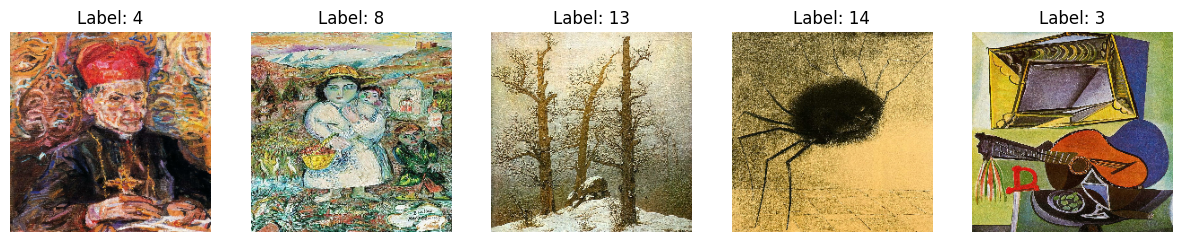

In [720]:
# Display some sample images from the training set
def display_sample_images(dataset, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i, (img, label) in enumerate(dataset.take(num_samples)):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img[0].numpy())
        plt.title(f"Label: {np.argmax(label[0].numpy())}")
        plt.axis('off')
    plt.show()
display_sample_images(train_ds)

## Handling Imbalanced Weights

In [704]:
from sklearn.utils import class_weight # For calculating class weights

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights calculated:")
for i, weight in class_weights_dict.items():
    print(f"  Class {grouped_styles[i]} (Index {i}): Weight {weight:.4f}")

Class weights calculated:
  Class Art Nouveau (Index 0): Weight 0.9882
  Class Baroque (Index 1): Weight 1.0067
  Class Color Field Painting (Index 2): Weight 1.0005
  Class Cubism (Index 3): Weight 1.0227
  Class Expressionism (Index 4): Weight 1.0309
  Class Fauvism (Index 5): Weight 1.0130
  Class Impressionism (Index 6): Weight 1.0052
  Class Minimalism (Index 7): Weight 1.0083
  Class Naive Art Primitivism (Index 8): Weight 1.0195
  Class Pop Art (Index 9): Weight 1.0178
  Class Realism (Index 10): Weight 0.9660
  Class Renaissance (Index 11): Weight 0.9822
  Class Rococo (Index 12): Weight 0.9646
  Class Romanticism (Index 13): Weight 1.0083
  Class Symbolism (Index 14): Weight 1.0099
  Class Ukiyo_e (Index 15): Weight 0.9632


In [705]:
unique_train_labels, train_counts = np.unique(y_train_labels, return_counts=True)
print("Training set class distribution:")
for label, count in zip(unique_train_labels, train_counts):
    print(f"Class {label} ({grouped_styles[label]}): {count} samples")

Training set class distribution:
Class 0 (Art Nouveau): 653 samples
Class 1 (Baroque): 641 samples
Class 2 (Color Field Painting): 645 samples
Class 3 (Cubism): 631 samples
Class 4 (Expressionism): 626 samples
Class 5 (Fauvism): 637 samples
Class 6 (Impressionism): 642 samples
Class 7 (Minimalism): 640 samples
Class 8 (Naive Art Primitivism): 633 samples
Class 9 (Pop Art): 634 samples
Class 10 (Realism): 668 samples
Class 11 (Renaissance): 657 samples
Class 12 (Rococo): 669 samples
Class 13 (Romanticism): 640 samples
Class 14 (Symbolism): 639 samples
Class 15 (Ukiyo_e): 670 samples


In [706]:
# Display the class distribution in the validation set
unique_val_labels, val_counts = np.unique(y_val_labels, return_counts=True)
print("Validation set class distribution:")
for label, count in zip(unique_val_labels, val_counts):
    print(f"Class {label} ({grouped_styles[label]}): {count} samples")

Validation set class distribution:
Class 0 (Art Nouveau): 140 samples
Class 1 (Baroque): 137 samples
Class 2 (Color Field Painting): 138 samples
Class 3 (Cubism): 136 samples
Class 4 (Expressionism): 135 samples
Class 5 (Fauvism): 137 samples
Class 6 (Impressionism): 137 samples
Class 7 (Minimalism): 137 samples
Class 8 (Naive Art Primitivism): 136 samples
Class 9 (Pop Art): 136 samples
Class 10 (Realism): 143 samples
Class 11 (Renaissance): 140 samples
Class 12 (Rococo): 143 samples
Class 13 (Romanticism): 137 samples
Class 14 (Symbolism): 137 samples
Class 15 (Ukiyo_e): 143 samples


In [707]:
# Display the class distribution in the test set
unique_test_labels, test_counts = np.unique(y_test_labels, return_counts=True)
print("Test set class distribution:")
for label, count in zip(unique_test_labels, test_counts):
    print(f"Class {label} ({grouped_styles[label]}): {count} samples")
    

Test set class distribution:
Class 0 (Art Nouveau): 140 samples
Class 1 (Baroque): 138 samples
Class 2 (Color Field Painting): 138 samples
Class 3 (Cubism): 135 samples
Class 4 (Expressionism): 134 samples
Class 5 (Fauvism): 136 samples
Class 6 (Impressionism): 138 samples
Class 7 (Minimalism): 137 samples
Class 8 (Naive Art Primitivism): 135 samples
Class 9 (Pop Art): 136 samples
Class 10 (Realism): 144 samples
Class 11 (Renaissance): 141 samples
Class 12 (Rococo): 143 samples
Class 13 (Romanticism): 137 samples
Class 14 (Symbolism): 137 samples
Class 15 (Ukiyo_e): 144 samples


## Model Training

In [708]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers


In [709]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience = 15,
    restore_best_weights=True,
    verbose=1,
    min_delta=1e-5,
)

In [710]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        # Reduce LR by half
    patience=10,        # Wait 3 epochs before reducing
    min_lr=1e-7,       # Don't go below this
    min_delta=1e-5,
    verbose=1
)

In [711]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 12))
  ax1.plot(history.history['accuracy'])
  ax1.plot(history.history['val_accuracy'])
  ax1.set_title('model accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'validation'], loc='upper left')
  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  ax2.set_title('model loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')

## VGG-13

In [712]:
vgg13 = Sequential([
  # Block 1 (64 filters)
  Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-3), input_shape=(224,224, 3)),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Block 2 (128 filters)
  Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Block 3 (256 filters)
  Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Block 4 (512 filters)
  Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Block 5 (optional, 512 filters, if image size allows further pooling)
  # For 128x128, a 5th pooling layer would lead to 4x4 or 2x2.
  Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(), Activation('relu'),
  Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(), Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Classification Head (modified for common practice and Grad-CAM)
  GlobalAveragePooling2D(),
  BatchNormalization(), # After pooling
  Dense(512, activation='relu', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(512, activation='relu', kernel_regularizer=l2(1e-3)),
  BatchNormalization(), # Added this
  Dropout(0.3),
  Dense(16, activation='softmax')
])

In [713]:
# Define the model
vgg13.build(input_shape=(image_height, image_width, 3))
vgg13.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 224, 224, 64)      0

In [714]:
# Initialize starting learning rate
base_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

vgg13.compile(
    optimizer=base_optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 
    metrics=['accuracy']
)

In [715]:
# Fit the model
history_vgg13 = vgg13.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    callbacks=[early_stop, reduce_lr],
    # class_weight = class_weights_dict only used if class imbalance is significant
)

Epoch 1/1000
323/323 [==============================] - 82s 243ms/step - loss: 6.4694 - accuracy: 0.2109 - val_loss: 9.2463 - val_accuracy: 0.0687 - lr: 1.0000e-04
Epoch 2/1000
323/323 [==============================] - 81s 243ms/step - loss: 6.1425 - accuracy: 0.2741 - val_loss: 5.8135 - val_accuracy: 0.3318 - lr: 1.0000e-04
Epoch 3/1000
323/323 [==============================] - 82s 245ms/step - loss: 5.8872 - accuracy: 0.3034 - val_loss: 5.7182 - val_accuracy: 0.3287 - lr: 1.0000e-04
Epoch 4/1000
323/323 [==============================] - 81s 244ms/step - loss: 5.6818 - accuracy: 0.3338 - val_loss: 5.4840 - val_accuracy: 0.3707 - lr: 1.0000e-04
Epoch 5/1000
323/323 [==============================] - 82s 246ms/step - loss: 5.5085 - accuracy: 0.3456 - val_loss: 5.3399 - val_accuracy: 0.3580 - lr: 1.0000e-04
Epoch 6/1000


KeyboardInterrupt: 

### Model Evaluation

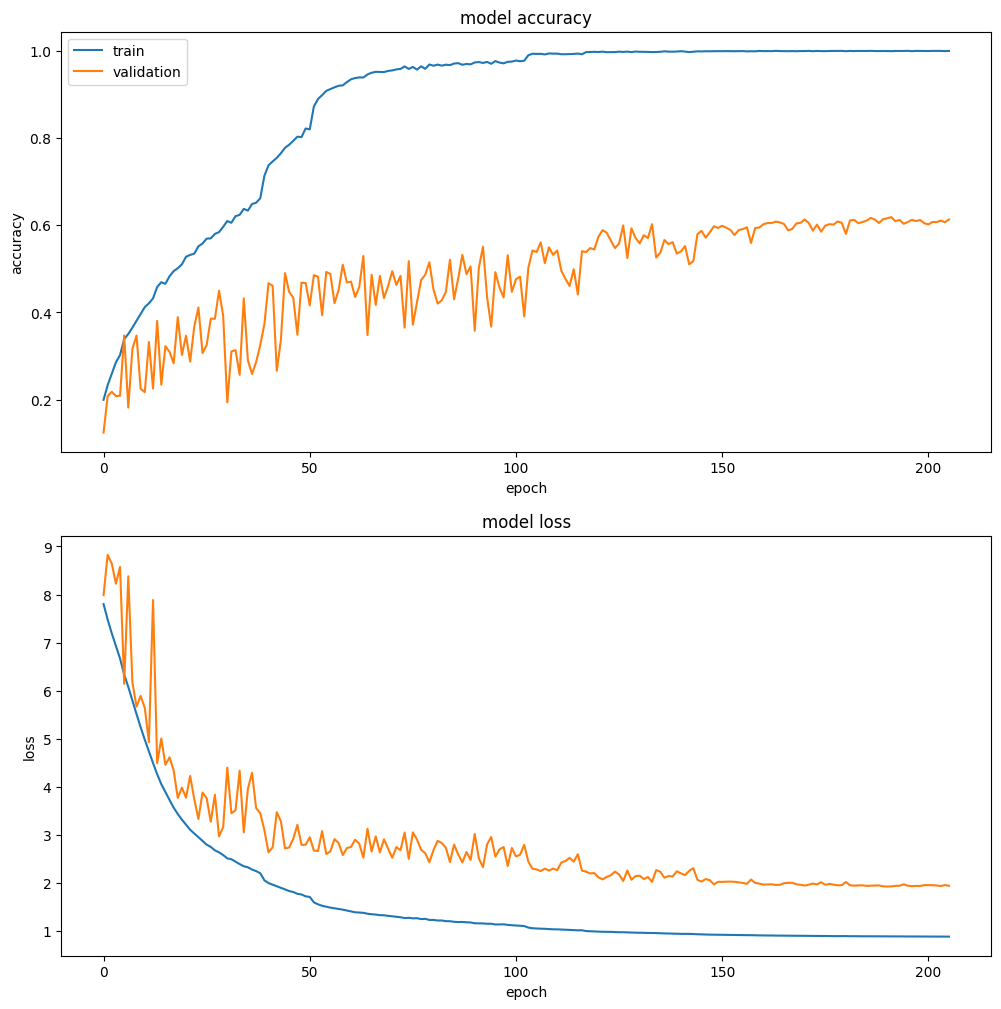

In [ ]:
# Plot Loss Graphs
plot_history(history_vgg13)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = vgg13.evaluate(test_ds)

70/70 [==============================] - 7s 101ms/step - loss: 2.0630 - accuracy: 0.5703


In [ ]:
# Print the test accuracy and loss
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 2.0630
Test Accuracy: 0.5703


In [ ]:
# Save the model as tflite
converter = tf.lite.TFLiteConverter.from_keras_model(vgg13)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('vgg13_gradcam.tflite', 'wb') as f:
    f.write(tflite_model)
    
# Save the model in HDF5 format
vgg13.save('vgg13_gradcam.h5')

# Save the model in SavedModel format
vgg13.save('vgg13_gradcam_saved_model', save_format='tf')

# Save the keras model
vgg13.save('vgg13_gradcam.keras')


INFO:tensorflow:Assets written to: C:\Users\Blix\AppData\Local\Temp\tmpx19ffv9l\assets


INFO:tensorflow:Assets written to: C:\Users\Blix\AppData\Local\Temp\tmpx19ffv9l\assets


INFO:tensorflow:Assets written to: vgg16_gradcam_saved_model\assets


INFO:tensorflow:Assets written to: vgg16_gradcam_saved_model\assets


In [ ]:
# Print Classification Report. Print which number represents which art style
from sklearn.metrics import classification_report
y_pred = vgg13.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Correct way to get true labels for comparison
y_true_labels_one_hot = []
for _, y_batch in test_ds:
    y_true_labels_one_hot.append(y_batch.numpy())

# Concatenate all one-hot batches and then convert them to integer labels
y_true_classes = np.argmax(np.concatenate(y_true_labels_one_hot, axis=0), axis=1)


print("Classification Report:")
# Ensure target_names matches the order of your class indices
print(classification_report(y_true_classes, y_pred_classes, target_names=grouped_styles))

70/70 [==============================] - 7s 97ms/step
Classification Report:
                       precision    recall  f1-score   support

          Art Nouveau       0.57      0.52      0.55       140
              Baroque       0.58      0.51      0.54       138
 Color Field Painting       0.76      0.72      0.74       138
               Cubism       0.78      0.74      0.76       135
        Expressionism       0.46      0.37      0.41       134
              Fauvism       0.46      0.38      0.41       136
        Impressionism       0.85      0.68      0.76       138
           Minimalism       0.61      0.72      0.66       137
Naive Art Primitivism       0.48      0.58      0.53       135
              Pop Art       0.39      0.74      0.51       136
              Realism       0.44      0.36      0.40       144
          Renaissance       0.71      0.56      0.63       141
               Rococo       0.67      0.53      0.59       143
          Romanticism       0.44      0.

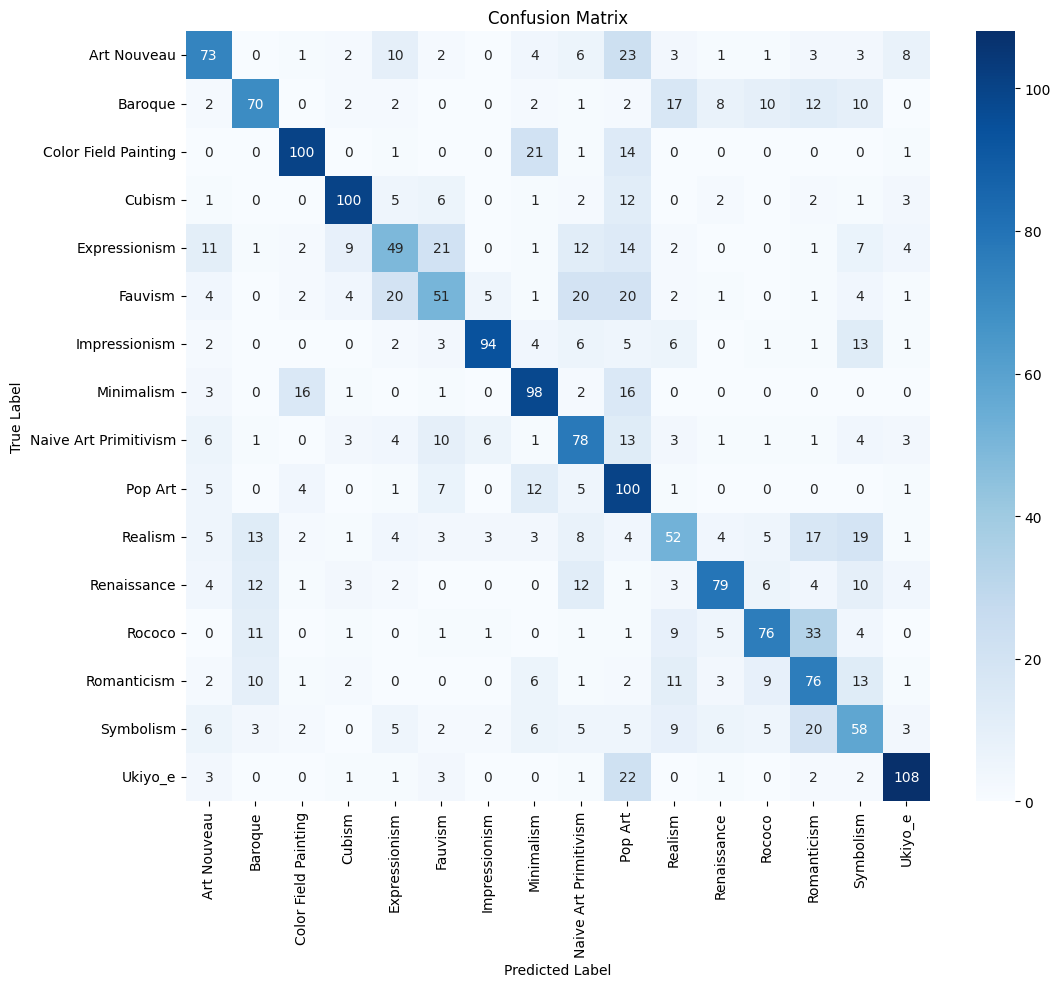

In [ ]:
# Generate Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=grouped_styles, yticklabels=grouped_styles)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Resnet-18

In [ ]:
def conv_block(x, filters, kernel_size=3, strides=1, use_projection=False, weight_decay=1e-3, name=None):
    l2 = regularizers.l2(weight_decay)

    shortcut = x
    if use_projection:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same',
                                 kernel_regularizer=l2, name=f'{name}_proj')(x)
        shortcut = layers.BatchNormalization(name=f'{name}_proj_bn')(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same',
                      kernel_regularizer=l2, name=f'{name}_conv1')(x)
    x = layers.BatchNormalization(name=f'{name}_bn1')(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same',
                      kernel_regularizer=l2, name=f'{name}_conv2')(x)
    x = layers.BatchNormalization(name=f'{name}_bn2')(x)

    x = layers.Add()([shortcut, x])
    x = layers.ReLU()(x)
    return x

def build_resnet18_gradcam(input_shape=(224, 224, 3), num_classes=len(grouped_styles), dropout_rate=0.3, weight_decay=1e-3):
    inputs = tf.keras.Input(shape=input_shape)
    l2 = regularizers.l2(weight_decay)

    # Initial Conv + MaxPool
    x = layers.Conv2D(64, 7, strides=2, padding='same', kernel_regularizer=l2, name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Conv2_x
    x = conv_block(x, 64, strides=1, use_projection=False, weight_decay=weight_decay, name='conv2_1')
    x = conv_block(x, 64, strides=1, use_projection=False, weight_decay=weight_decay, name='conv2_2')

    # Conv3_x
    x = conv_block(x, 128, strides=2, use_projection=True, weight_decay=weight_decay, name='conv3_1')
    x = conv_block(x, 128, strides=1, use_projection=False, weight_decay=weight_decay, name='conv3_2')

    # Conv4_x
    x = conv_block(x, 256, strides=2, use_projection=True, weight_decay=weight_decay, name='conv4_1')
    x = conv_block(x, 256, strides=1, use_projection=False, weight_decay=weight_decay, name='conv4_2')

    # Conv5_x
    x = conv_block(x, 512, strides=2, use_projection=True, weight_decay=weight_decay, name='conv5_1')
    x = conv_block(x, 512, strides=1, use_projection=False, weight_decay=weight_decay, name='conv5_2')
    last_conv_output = x  # For Grad-CAM

    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2, name='fc')(x)

    model = models.Model(inputs=inputs, outputs=x, name='ResNet18_GradCAM')
    return model

In [ ]:
# Define the model
resnet18_gradcam = build_resnet18_gradcam(input_shape=(image_height, image_width, 3), num_classes=num_classes, dropout_rate=0.5, weight_decay=1e-3)
resnet18_gradcam.summary()

Model: "ResNet18_GradCAM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 112, 112, 64  256         ['conv1[0][0]']                  
                                )                                                  

In [ ]:
# Initialize starting learning rate
base_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

resnet18_gradcam.compile(
    optimizer=base_optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 
    metrics=['accuracy']
)

In [ ]:
# Fit the model
resnet18_gradcam_history = resnet18_gradcam.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    callbacks=[early_stop, reduce_lr],
    # class_weight = class_weights_dict only used if class imbalance is significant
)

Epoch 1/1000
323/323 [==============================] - 95s 266ms/step - loss: 6.8325 - accuracy: 0.2160 - val_loss: 7.6430 - val_accuracy: 0.0809 - lr: 1.0000e-04
Epoch 2/1000
323/323 [==============================] - 93s 263ms/step - loss: 6.1941 - accuracy: 0.2996 - val_loss: 6.5076 - val_accuracy: 0.2007 - lr: 1.0000e-04
Epoch 3/1000
323/323 [==============================] - 94s 264ms/step - loss: 5.7986 - accuracy: 0.3401 - val_loss: 8.0103 - val_accuracy: 0.1994 - lr: 1.0000e-04
Epoch 4/1000
323/323 [==============================] - 93s 262ms/step - loss: 5.4016 - accuracy: 0.3719 - val_loss: 6.1043 - val_accuracy: 0.2419 - lr: 1.0000e-04
Epoch 5/1000
323/323 [==============================] - 93s 261ms/step - loss: 5.0558 - accuracy: 0.3963 - val_loss: 5.4855 - val_accuracy: 0.2572 - lr: 1.0000e-04
Epoch 6/1000
323/323 [==============================] - 93s 261ms/step - loss: 4.7104 - accuracy: 0.4175 - val_loss: 5.8738 - val_accuracy: 0.2125 - lr: 1.0000e-04
Epoch 7/1000
323

### Model Evaluation

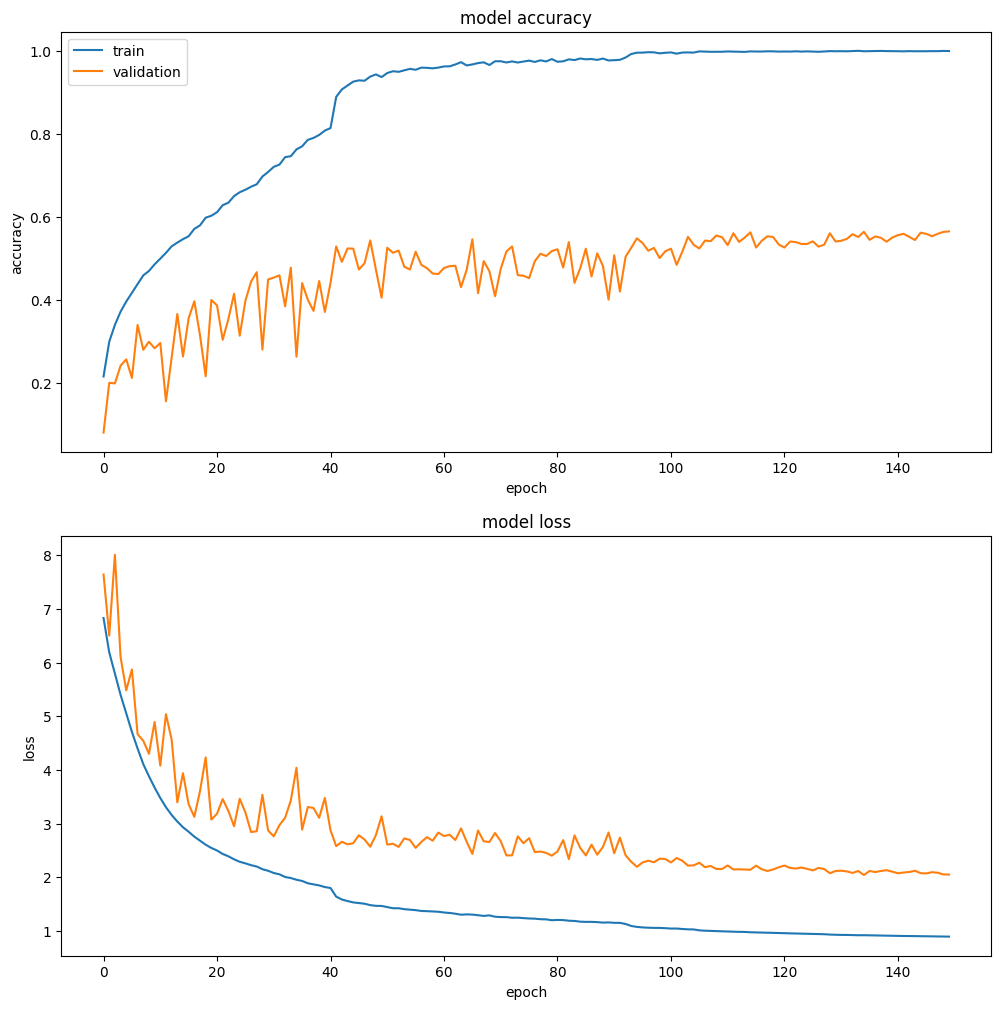

In [ ]:
# Plot Loss Graphs
plot_history(resnet18_gradcam_history)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = resnet18_gradcam.evaluate(test_ds)

70/70 [==============================] - 6s 80ms/step - loss: 2.1276 - accuracy: 0.5463


In [ ]:
# Print the test accuracy and loss
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 2.1276
Test Accuracy: 0.5463


In [ ]:
# Save the model as tflite
converter = tf.lite.TFLiteConverter.from_keras_model(resnet18_gradcam)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('resnet18_gradcam.tflite', 'wb') as f:
    f.write(tflite_model)
    
# Save the model in HDF5 format
resnet18_gradcam.save('resnet18_gradcam.h5')

# Save the model in SavedModel format
resnet18_gradcam.save('resnet18_gradcam_saved_model', save_format='tf')

# Save the keras model
resnet18_gradcam.save('resnet18_gradcam.keras')


INFO:tensorflow:Assets written to: C:\Users\Blix\AppData\Local\Temp\tmpk5_dw8ix\assets


INFO:tensorflow:Assets written to: C:\Users\Blix\AppData\Local\Temp\tmpk5_dw8ix\assets


INFO:tensorflow:Assets written to: resnet18_gradcam_saved_model\assets


INFO:tensorflow:Assets written to: resnet18_gradcam_saved_model\assets


In [ ]:
# Print Classification Report. Print which number represents which art style
from sklearn.metrics import classification_report
y_pred = resnet18_gradcam.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Correct way to get true labels for comparison
y_true_labels_one_hot = []
for _, y_batch in test_ds:
    y_true_labels_one_hot.append(y_batch.numpy())

# Concatenate all one-hot batches and then convert them to integer labels
y_true_classes = np.argmax(np.concatenate(y_true_labels_one_hot, axis=0), axis=1)


print("Classification Report:")
# Ensure target_names matches the order of your class indices
print(classification_report(y_true_classes, y_pred_classes, target_names=grouped_styles))

70/70 [==============================] - 6s 85ms/step
Classification Report:
                       precision    recall  f1-score   support

          Art Nouveau       0.44      0.44      0.44       140
              Baroque       0.60      0.39      0.47       138
 Color Field Painting       0.77      0.66      0.71       138
               Cubism       0.63      0.76      0.69       135
        Expressionism       0.39      0.49      0.43       134
              Fauvism       0.53      0.35      0.42       136
        Impressionism       0.66      0.76      0.71       138
           Minimalism       0.63      0.71      0.66       137
Naive Art Primitivism       0.54      0.47      0.51       135
              Pop Art       0.40      0.70      0.51       136
              Realism       0.56      0.35      0.43       144
          Renaissance       0.64      0.41      0.50       141
               Rococo       0.62      0.59      0.60       143
          Romanticism       0.48      0.

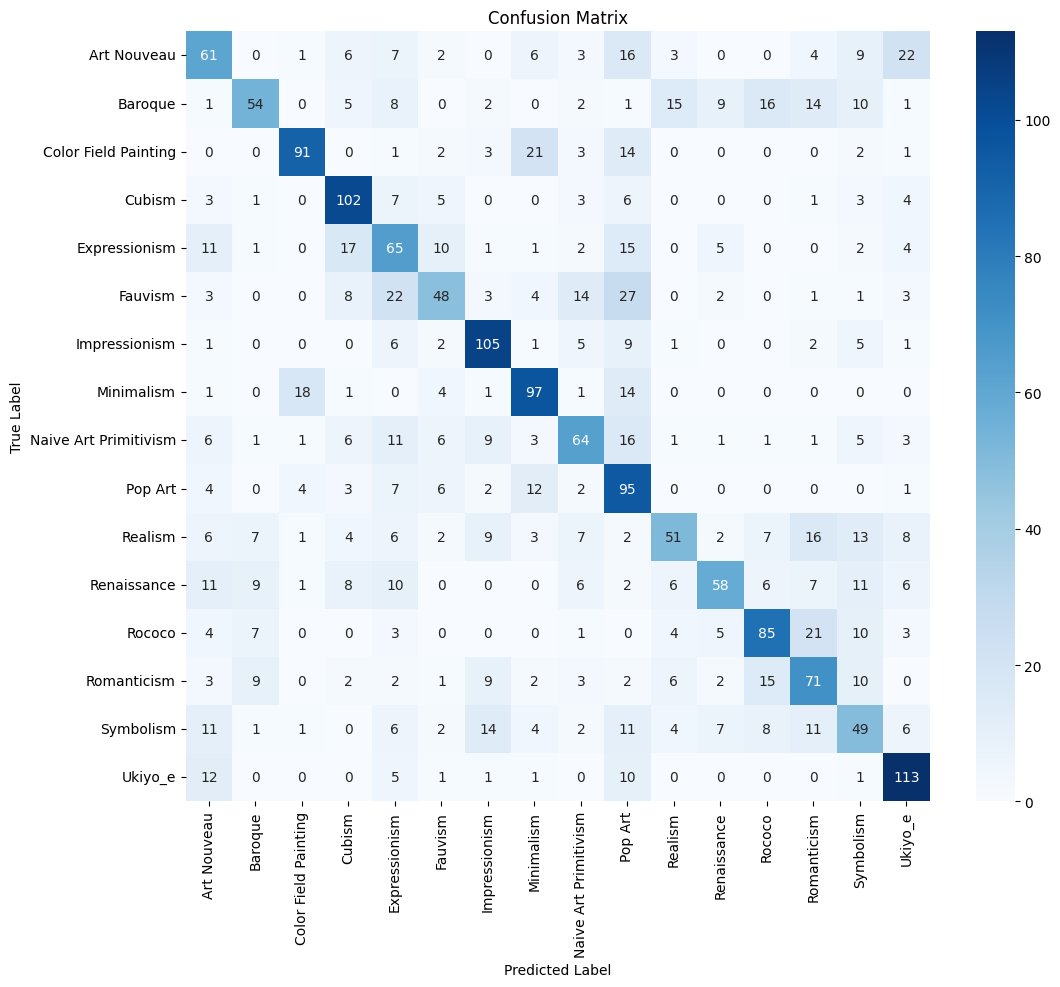

In [ ]:
# Generate Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=grouped_styles, yticklabels=grouped_styles)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## VGG-16

In [ ]:
vgg16 = Sequential([
  # Block 1 (64 filters)
  Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-3), input_shape=(224,224, 3)),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Block 2 (128 filters)
  Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Block 3 (256 filters)
  Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-3)), # VGG16 has 3 conv layers here
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Block 4 (512 filters)
  Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Block 5 (optional, 512 filters, if image size allows further pooling)
  # For 128x128, a 5th pooling layer would lead to 4x4 or 2x2.
  Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(), Activation('relu'),
  Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(), Activation('relu'),
  Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(), Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Classification Head (modified for common practice and Grad-CAM)
  GlobalAveragePooling2D(),
  BatchNormalization(), # After pooling
  Dense(512, activation='relu', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(512, activation='relu', kernel_regularizer=l2(1e-3)),
  BatchNormalization(), # Added this
  Dropout(0.3),
  Dense(16, activation='softmax')
])

In [ ]:
# Define the model
vgg16.build(input_shape=(image_height, image_width, 3))
vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 224, 224, 64)      0

In [ ]:
# Initialize starting learning rate
base_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

vgg16.compile(
    optimizer=base_optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 
    metrics=['accuracy']
)

In [ ]:
# Fit the model
history_vgg16 = vgg16.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    callbacks=[early_stop, reduce_lr],
    # class_weight = class_weights_dict only used if class imbalance is significant
)

Epoch 1/1000
323/323 [==============================] - 135s 383ms/step - loss: 7.8010 - accuracy: 0.1999 - val_loss: 7.9868 - val_accuracy: 0.1248 - lr: 1.0000e-04
Epoch 2/1000
323/323 [==============================] - 131s 373ms/step - loss: 7.4779 - accuracy: 0.2336 - val_loss: 8.8252 - val_accuracy: 0.2084 - lr: 1.0000e-04
Epoch 3/1000
323/323 [==============================] - 129s 367ms/step - loss: 7.1925 - accuracy: 0.2600 - val_loss: 8.6412 - val_accuracy: 0.2184 - lr: 1.0000e-04
Epoch 4/1000
323/323 [==============================] - 130s 368ms/step - loss: 6.9318 - accuracy: 0.2859 - val_loss: 8.2240 - val_accuracy: 0.2084 - lr: 1.0000e-04
Epoch 5/1000
323/323 [==============================] - 129s 367ms/step - loss: 6.6696 - accuracy: 0.3026 - val_loss: 8.5714 - val_accuracy: 0.2093 - lr: 1.0000e-04
Epoch 6/1000
323/323 [==============================] - 129s 366ms/step - loss: 6.3387 - accuracy: 0.3390 - val_loss: 6.1442 - val_accuracy: 0.3476 - lr: 1.0000e-04
Epoch 7/10

### Model Evaluation

In [ ]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 12))
  ax1.plot(history.history['accuracy'])
  ax1.plot(history.history['val_accuracy'])
  ax1.set_title('model accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'validation'], loc='upper left')
  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  ax2.set_title('model loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')

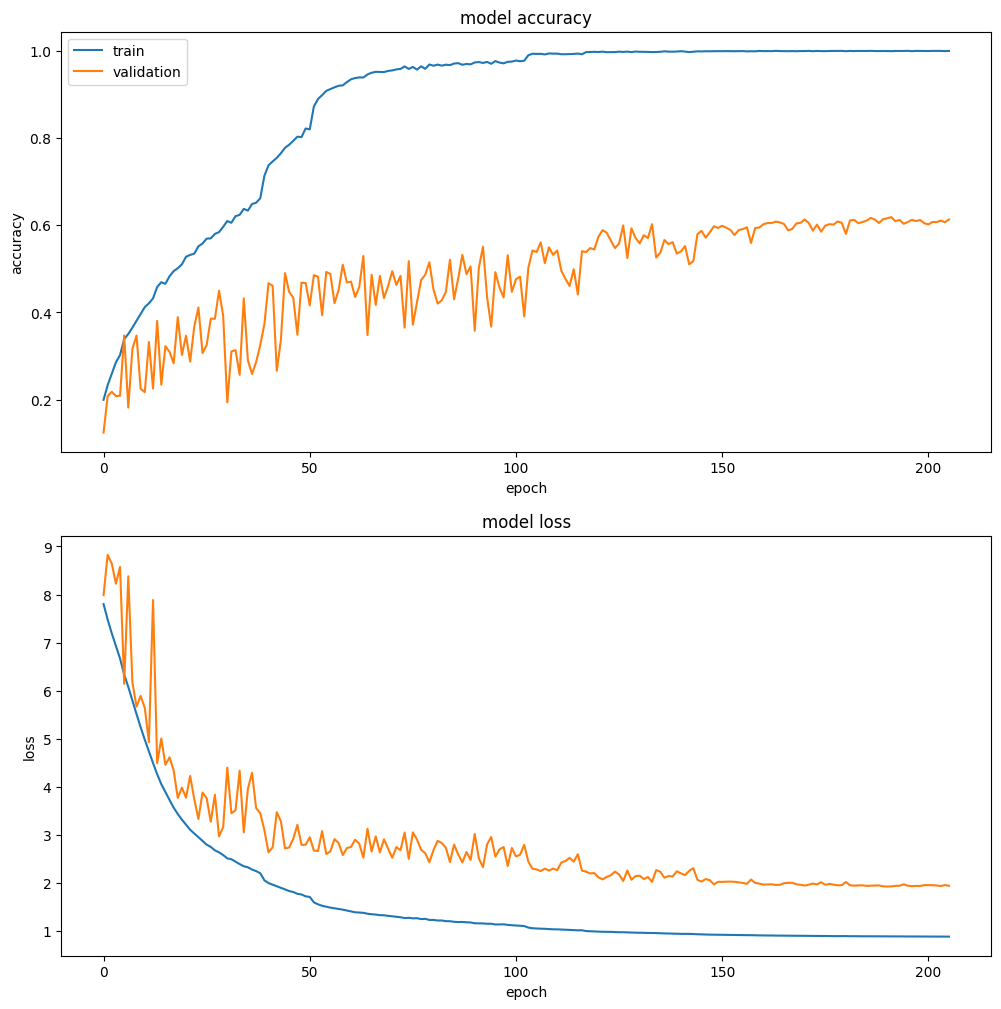

In [ ]:
# Plot Loss Graphs
plot_history(history_vgg16)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = vgg16.evaluate(test_ds)

70/70 [==============================] - 7s 101ms/step - loss: 2.0630 - accuracy: 0.5703


In [ ]:
# Print the test accuracy and loss
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 2.0630
Test Accuracy: 0.5703


In [ ]:
# Save the model as tflite
converter = tf.lite.TFLiteConverter.from_keras_model(vgg16)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('vgg16_gradcam.tflite', 'wb') as f:
    f.write(tflite_model)
    
# Save the model in HDF5 format
vgg16.save('vgg16_gradcam.h5')

# Save the model in SavedModel format
vgg16.save('vgg16_gradcam_saved_model', save_format='tf')

# Save the keras model
vgg16.save('vgg16_gradcam.keras')


INFO:tensorflow:Assets written to: C:\Users\Blix\AppData\Local\Temp\tmpx19ffv9l\assets


INFO:tensorflow:Assets written to: C:\Users\Blix\AppData\Local\Temp\tmpx19ffv9l\assets


INFO:tensorflow:Assets written to: vgg16_gradcam_saved_model\assets


INFO:tensorflow:Assets written to: vgg16_gradcam_saved_model\assets


In [ ]:
# Print Classification Report. Print which number represents which art style
from sklearn.metrics import classification_report
y_pred = vgg16.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Correct way to get true labels for comparison
y_true_labels_one_hot = []
for _, y_batch in test_ds:
    y_true_labels_one_hot.append(y_batch.numpy())

# Concatenate all one-hot batches and then convert them to integer labels
y_true_classes = np.argmax(np.concatenate(y_true_labels_one_hot, axis=0), axis=1)


print("Classification Report:")
# Ensure target_names matches the order of your class indices
print(classification_report(y_true_classes, y_pred_classes, target_names=grouped_styles))

70/70 [==============================] - 7s 97ms/step
Classification Report:
                       precision    recall  f1-score   support

          Art Nouveau       0.57      0.52      0.55       140
              Baroque       0.58      0.51      0.54       138
 Color Field Painting       0.76      0.72      0.74       138
               Cubism       0.78      0.74      0.76       135
        Expressionism       0.46      0.37      0.41       134
              Fauvism       0.46      0.38      0.41       136
        Impressionism       0.85      0.68      0.76       138
           Minimalism       0.61      0.72      0.66       137
Naive Art Primitivism       0.48      0.58      0.53       135
              Pop Art       0.39      0.74      0.51       136
              Realism       0.44      0.36      0.40       144
          Renaissance       0.71      0.56      0.63       141
               Rococo       0.67      0.53      0.59       143
          Romanticism       0.44      0.

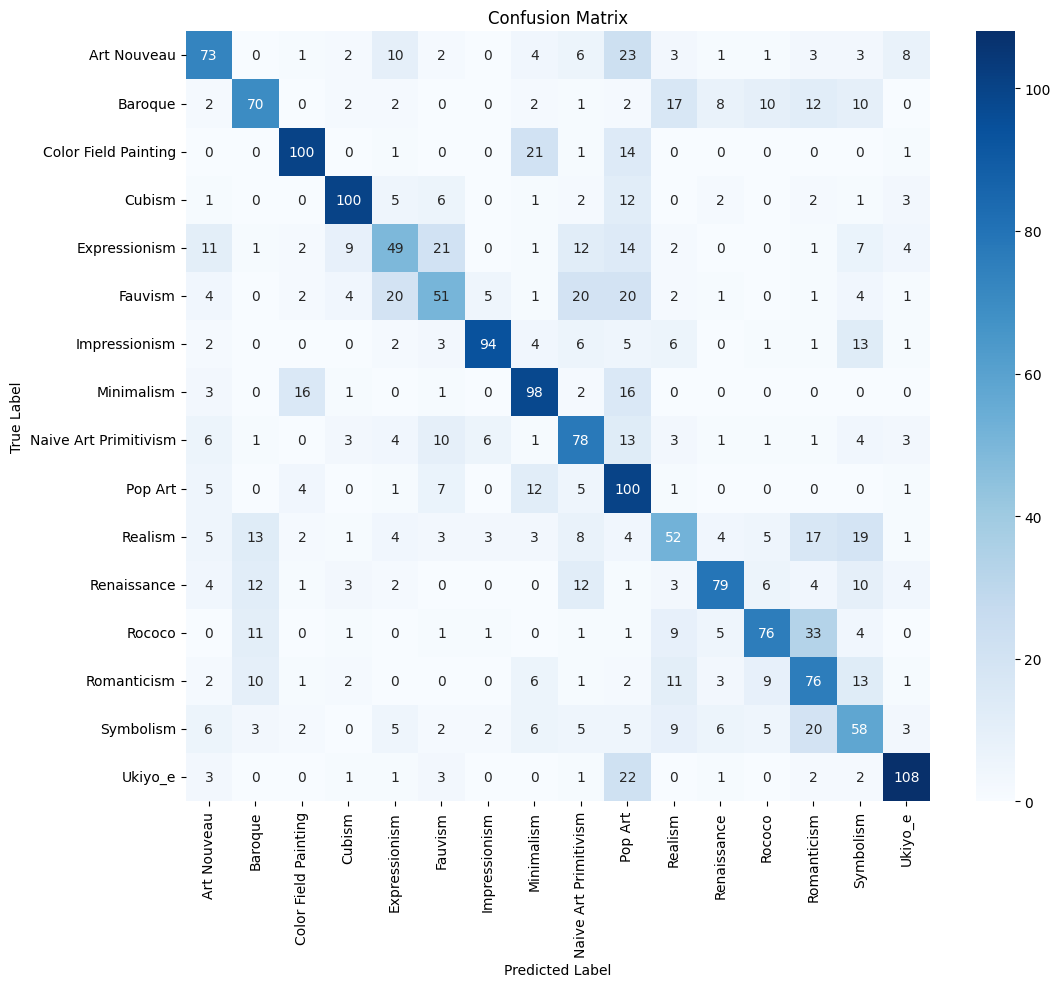

In [ ]:
# Generate Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=grouped_styles, yticklabels=grouped_styles)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## ResNet-34

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def basic_block(x, filters, strides=1, use_projection=False, weight_decay=1e-3, name=""):
    l2 = regularizers.l2(weight_decay)
    shortcut = x

    if use_projection:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same',
                                 kernel_regularizer=l2, name=f"{name}_proj_conv")(shortcut)
        shortcut = layers.BatchNormalization(name=f"{name}_proj_bn")(shortcut)

    x = layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same',
                      kernel_regularizer=l2, name=f"{name}_conv1")(x)
    x = layers.BatchNormalization(name=f"{name}_bn1")(x)
    x = layers.ReLU(name=f"{name}_relu1")(x)

    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same',
                      kernel_regularizer=l2, name=f"{name}_conv2")(x)
    x = layers.BatchNormalization(name=f"{name}_bn2")(x)

    x = layers.Add(name=f"{name}_add")([x, shortcut])
    x = layers.ReLU(name=f"{name}_relu2")(x)
    return x

def build_resnet34_gradcam(input_shape=(224, 224, 3), num_classes=1000, dropout_rate=0.5, weight_decay=1e-3):
    inputs = tf.keras.Input(shape=input_shape)
    l2 = regularizers.l2(weight_decay)

    # Initial stem
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same',
                      kernel_regularizer=l2, name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.ReLU(name='relu_conv1')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Conv2_x (3 blocks of 64 filters)
    for i in range(3):
        x = basic_block(x, 64, strides=1, use_projection=False, weight_decay=weight_decay, name=f'conv2_{i+1}')

    # Conv3_x (4 blocks of 128 filters, first block uses projection)
    x = basic_block(x, 128, strides=2, use_projection=True, weight_decay=weight_decay, name='conv3_1')
    for i in range(1, 4):
        x = basic_block(x, 128, strides=1, use_projection=False, weight_decay=weight_decay, name=f'conv3_{i+1}')

    # Conv4_x (6 blocks of 256 filters, first block uses projection)
    x = basic_block(x, 256, strides=2, use_projection=True, weight_decay=weight_decay, name='conv4_1')
    for i in range(1, 6):
        x = basic_block(x, 256, strides=1, use_projection=False, weight_decay=weight_decay, name=f'conv4_{i+1}')

    # Conv5_x (3 blocks of 512 filters, first block uses projection)
    x = basic_block(x, 512, strides=2, use_projection=True, weight_decay=weight_decay, name='conv5_1')
    x = basic_block(x, 512, strides=1, use_projection=False, weight_decay=weight_decay, name='conv5_2')
    x = basic_block(x, 512, strides=1, use_projection=False, weight_decay=weight_decay, name='conv5_3')
    last_conv_output = x  # For Grad-CAM

    # Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(16, activation='softmax', kernel_regularizer=l2, name='fc')(x)

    model = models.Model(inputs=inputs, outputs=x, name='ResNet34_GradCAM')
    return model

In [ ]:
# Define the model
resnet34_gradcam = build_resnet34_gradcam(input_shape=(image_height, image_width, 3), num_classes=num_classes, dropout_rate=0.5, weight_decay=1e-3)
resnet34_gradcam.summary()

Model: "ResNet34_GradCAM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 112, 112, 64  256         ['conv1[0][0]']                  
                                )                                                  

In [ ]:
# Initialize starting learning rate
base_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

resnet34_gradcam.compile(
    optimizer=base_optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 
    metrics=['accuracy']
)

In [ ]:
# Fit the model
resnet34_gradcam_history = resnet34_gradcam.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    callbacks=[early_stop, reduce_lr]
    # class_weight = class_weights_dict only used if class imbalance is significant
)

Epoch 1/1000
323/323 [==============================] - 140s 391ms/step - loss: 10.6509 - accuracy: 0.1949 - val_loss: 11.3953 - val_accuracy: 0.1085 - lr: 1.0000e-04
Epoch 2/1000
323/323 [==============================] - 134s 382ms/step - loss: 9.6686 - accuracy: 0.2772 - val_loss: 11.1823 - val_accuracy: 0.1867 - lr: 1.0000e-04
Epoch 3/1000
323/323 [==============================] - 135s 382ms/step - loss: 8.9183 - accuracy: 0.3062 - val_loss: 8.5545 - val_accuracy: 0.3187 - lr: 1.0000e-04
Epoch 4/1000
323/323 [==============================] - 133s 376ms/step - loss: 8.1626 - accuracy: 0.3433 - val_loss: 9.5777 - val_accuracy: 0.1451 - lr: 1.0000e-04
Epoch 5/1000
323/323 [==============================] - 131s 372ms/step - loss: 7.4653 - accuracy: 0.3542 - val_loss: 7.4771 - val_accuracy: 0.2631 - lr: 1.0000e-04
Epoch 6/1000
323/323 [==============================] - 132s 374ms/step - loss: 6.7667 - accuracy: 0.3887 - val_loss: 6.9671 - val_accuracy: 0.2464 - lr: 1.0000e-04
Epoch 7

### Model Evaluation

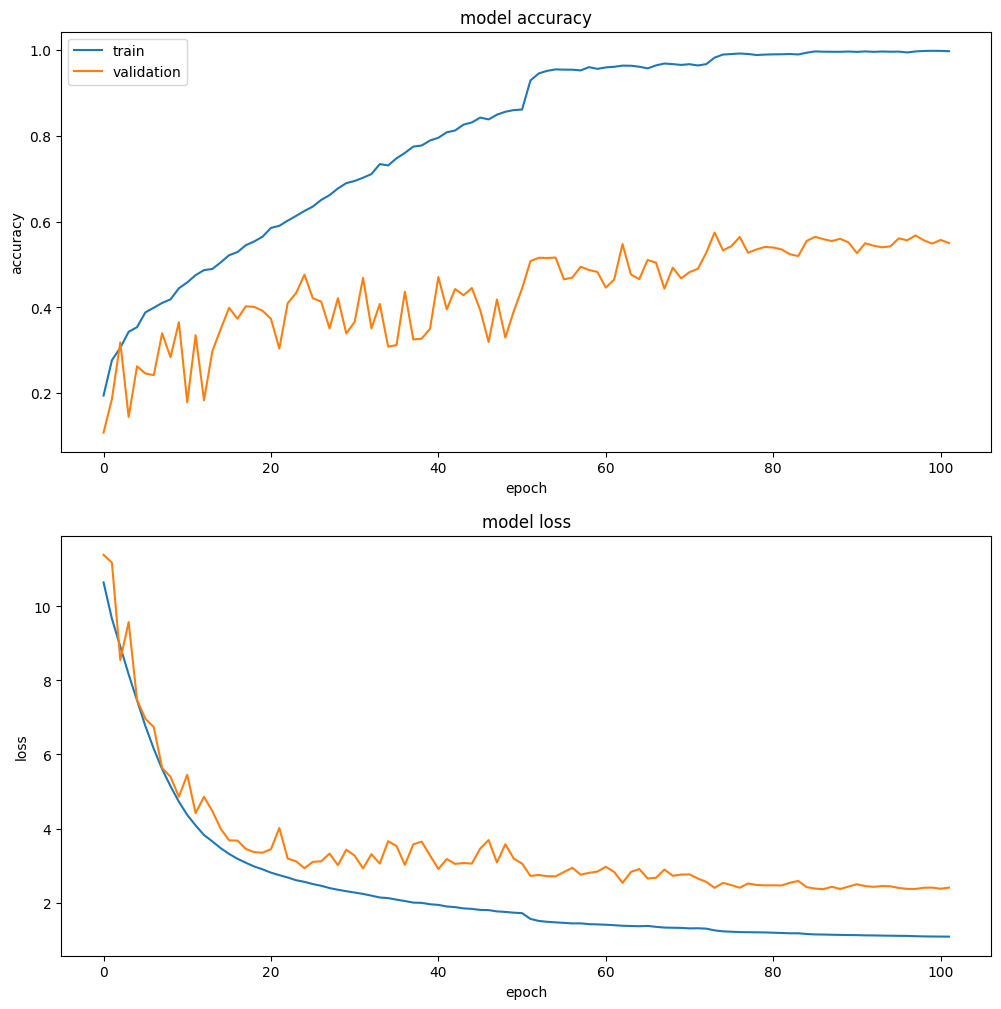

In [ ]:
# Plot Loss Graphs
plot_history(resnet34_gradcam_history)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = resnet34_gradcam.evaluate(test_ds)

70/70 [==============================] - 7s 103ms/step - loss: 2.4536 - accuracy: 0.5296


In [ ]:
# Print the test accuracy and loss
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 2.4536
Test Accuracy: 0.5296


In [ ]:
# Save the model as tflite
converter = tf.lite.TFLiteConverter.from_keras_model(resnet34_gradcam)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('resnet34_gradcam.tflite', 'wb') as f:
    f.write(tflite_model)
    
# Save the model in HDF5 format
resnet34_gradcam.save('resnet34_gradcam_model.h5')

# Save the model in SavedModel format
resnet34_gradcam.save('resnet34_gradcam_model_saved_model', save_format='tf')

# Save the keras model
resnet34_gradcam.save('resnet34_gradcam_model.keras')


INFO:tensorflow:Assets written to: C:\Users\Blix\AppData\Local\Temp\tmp6junpb0x\assets


INFO:tensorflow:Assets written to: C:\Users\Blix\AppData\Local\Temp\tmp6junpb0x\assets


INFO:tensorflow:Assets written to: resnet34_gradcam_model_saved_model\assets


INFO:tensorflow:Assets written to: resnet34_gradcam_model_saved_model\assets


In [ ]:
# Print Classification Report. Print which number represents which art style
from sklearn.metrics import classification_report
y_pred = resnet34_gradcam.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Correct way to get true labels for comparison
y_true_labels_one_hot = []
for _, y_batch in test_ds:
    y_true_labels_one_hot.append(y_batch.numpy())

# Concatenate all one-hot batches and then convert them to integer labels
y_true_classes = np.argmax(np.concatenate(y_true_labels_one_hot, axis=0), axis=1)


print("Classification Report:")
# Ensure target_names matches the order of your class indices
print(classification_report(y_true_classes, y_pred_classes, target_names=grouped_styles))

70/70 [==============================] - 8s 112ms/step
Classification Report:
                       precision    recall  f1-score   support

          Art Nouveau       0.38      0.61      0.47       140
              Baroque       0.59      0.37      0.46       138
 Color Field Painting       0.74      0.72      0.73       138
               Cubism       0.71      0.51      0.59       135
        Expressionism       0.29      0.36      0.32       134
              Fauvism       0.50      0.38      0.43       136
        Impressionism       0.59      0.80      0.68       138
           Minimalism       0.68      0.66      0.67       137
Naive Art Primitivism       0.47      0.46      0.47       135
              Pop Art       0.42      0.71      0.53       136
              Realism       0.53      0.38      0.44       144
          Renaissance       0.63      0.37      0.47       141
               Rococo       0.64      0.60      0.62       143
          Romanticism       0.49      0

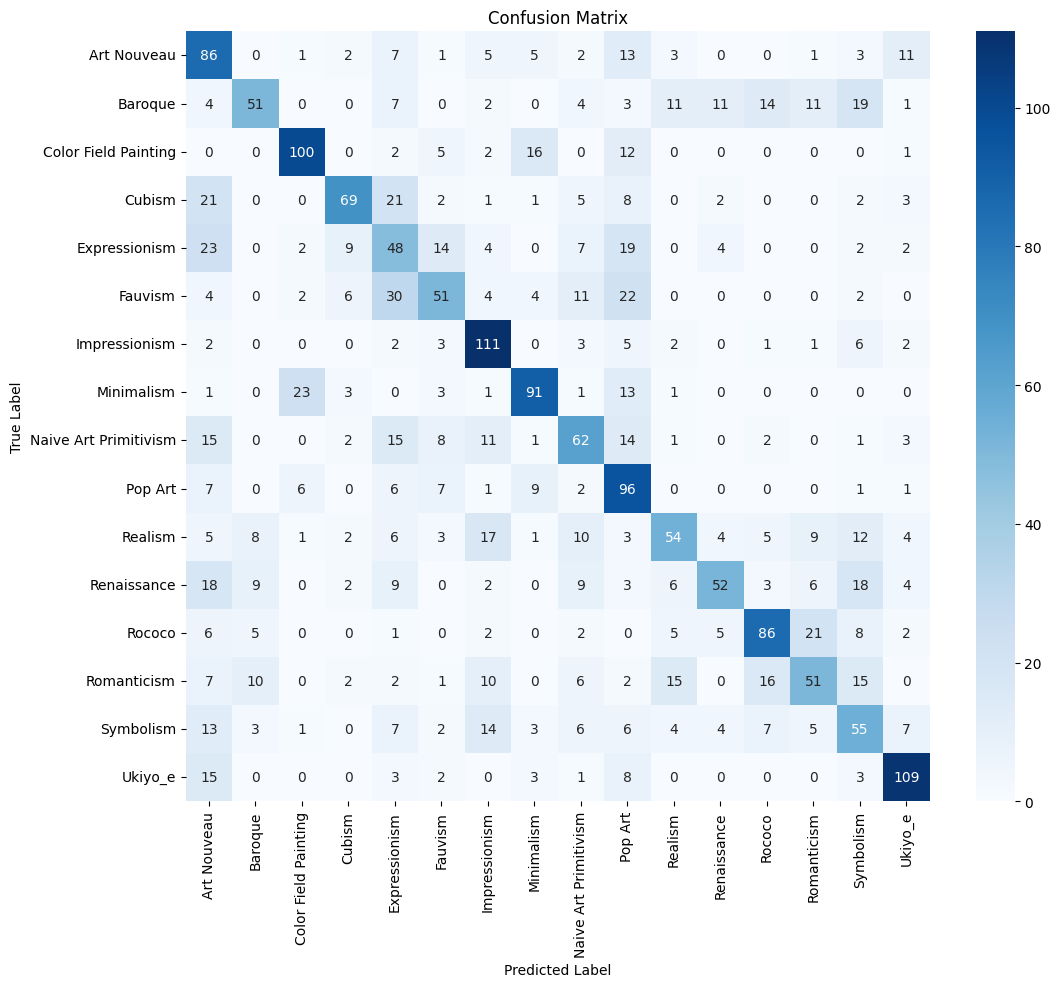

In [ ]:
# Generate Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=grouped_styles, yticklabels=grouped_styles)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
